In [12]:
# %pip install pandas numpy uvicorn fastapi pydantic cuda-toolkit==12.8 nvidia-cudnn-cu12==9.7.0.66 tf-nightly keras-nlp

In [13]:
from IPython.display import display, Markdown

from pandas import DataFrame, Series
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# TensorFlow et Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TextVectorization
import keras_nlp

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")


TensorFlow version: 2.19.1
Keras version: 3.12.0
KerasNLP version: 0.24.0
⚠️  Aucun GPU détecté - Utilisation du CPU


In [14]:
original_df: DataFrame = pd.read_parquet('https://huggingface.co/api/datasets/textdetox/multilingual_toxicity_dataset/parquet/default/fr/0.parquet')

In [15]:
df = original_df.sample(frac=1)
df.head(5).reset_index(drop=True)

,text,toxic
0,n hesitez pas a utiliser le bouton Prévisualis...,0
1,Je vais te les faire bouffer en salade avec ta...,1
2,C'est vrai que les parisiennes ont les têtes d...,1
3,C’est elle qui a conduit à la situation « post...,0
4,"En fait, ils ont repris les codes de com du FN...",0


# EDA et traitement des données

In [16]:
# Recherche d'éléments manquants
df_notna_count = len(df)
df.dropna(inplace=True)
print(f"{len(df)}/{df_notna_count} messages restants après retrait d'éventuels manque dans les données ou les labels")

5000/5000 messages restants après retrait d'éventuels manque dans les données ou les labels


In [17]:
from tensorflow import Tensor


def custom_standardisation(t: Tensor) -> Tensor:
    # https://github.com/google/re2/wiki/Syntax
    # Remplacement manuel des lettres accentuées
    t = tf.strings.regex_replace(t, "[éèêë]", "e")
    t = tf.strings.regex_replace(t, "[ÉÈÊË]", "E")
    t = tf.strings.regex_replace(t, "[àâä]", "a")
    t = tf.strings.regex_replace(t, "[ÀÂÄ]", "A")
    t = tf.strings.regex_replace(t, "[îï]", "i")
    t = tf.strings.regex_replace(t, "[ÎÏ]", "I")
    t = tf.strings.regex_replace(t, "[ôö]", "o")
    t = tf.strings.regex_replace(t, "[ÔÖ]", "O")
    t = tf.strings.regex_replace(t, "[ùûü]", "u")
    t = tf.strings.regex_replace(t, "[ÙÛÜ]", "U")
    t = tf.strings.regex_replace(t, "ç", "c")
    t = tf.strings.regex_replace(t, "Ç", "C")
    t = tf.strings.regex_replace(t, "ÿ", "y")
    t = tf.strings.regex_replace(t, "Ÿ", "Y")

    t = tf.strings.lower(t)
    t = tf.strings.regex_replace(t, r"[a-z]+://[^ ]+", "") # retrait d'url
    t = tf.strings.regex_replace(t, r"<[^>]+>", " ") # strip html tags

    t = tf.strings.regex_replace(t, r"\pP", "") # Retrait de poncutation
    t = tf.strings.regex_replace(t, r"\pS", "") # Retrait de Symboles
    t = tf.strings.regex_replace(t, r"[^\p{Latin} ]", "") # Retrait de poncutation
    
    t = tf.strings.regex_replace(t, r"(\b\w\b)", "") # retrait des mots de moins de 2 lettres
    t = tf.strings.regex_replace(t, r"\s+", " ") # retrait des espaces en trop

    t = tf.strings.strip(t)

    t = tf.strings.regex_replace(t, r"^$", "[UNK]") # en cas de chaine vide, renvois le tag [UNK] utilisé par défaut

    return t

In [18]:
# Tokenizer for stats
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
    # split = "whitespace",
    # output_sequence_length=32,
)

tokenizer.adapt(df['text'])

In [19]:
print(tokenizer.vocabulary_size()) # TODO: a optimiser avec la lemmatisation

13552


In [20]:
vocab = tokenizer.get_vocabulary()

def clean_text(text: str):
    try:
        return ' '.join([vocab[tok] for tok in np.array(tokenizer(text)).tolist() if tok > 0])
    except Exception as e:
        print(e, text)


df['text_clean'] = df['text'].apply(clean_text)
print(df.head())

                                                   text  toxic  \
1501  n hesitez pas a utiliser le bouton Prévisualis...      0   
2586  Je vais te les faire bouffer en salade avec ta...      1   
2653  C'est vrai que les parisiennes ont les têtes d...      1   
1055  C’est elle qui a conduit à la situation « post...      0   
705   En fait, ils ont repris les codes de com du FN...      0   

                                             text_clean  
1501  hesitez pas utiliser le bouton previsualiser c...  
2586  je vais te les faire bouffer en salade avec ta...  
2653  cest vrai que les parisiennes ont les tetes de...  
1055  cest elle qui conduit la situation postdemocra...  
705   en fait ils ont repris les codes de com du fn ...  


In [21]:
df['text_size'] = df['text_clean'].map(lambda x: len(x.split()))
# print(df.head())
# print('===============')
# print(df['text_size'].value_counts())
# print('===============')
for i in df[df['text'].str.contains('jsuis')].index:
    print(df.loc[i,'text'])
    print(df.loc[i,'text_clean'])


 Arrête cette passion de merde bordel jsuis sur que tu met soigneusement tes putain de timbres dans des livres classés par pays que tu prend plaisir à contempler comme un putain d'autiste au lieu d'apprendre des vrais trucs comme savoir te défendre ou te faire des amis.
arrete cette passion de merde bordel jsuis sur que tu met soigneusement tes putain de timbres dans des livres classes par pays que tu prend plaisir contempler comme un putain dautiste au lieu dapprendre des vrais trucs comme savoir te defendre ou te faire des amis


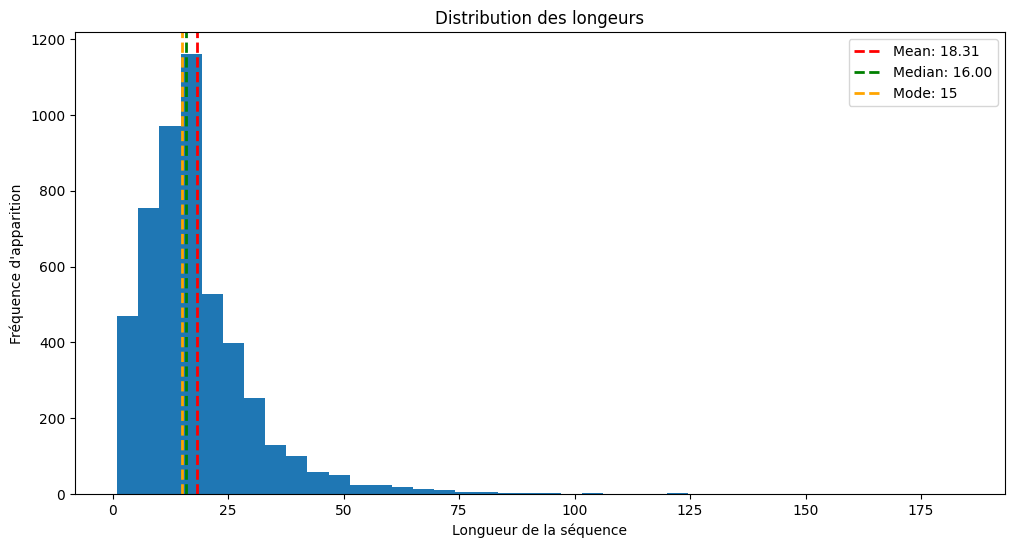

In [22]:

plt.figure(figsize=(12, 6))
plt.hist(
    x=df['text_size'],
    bins=40
)

sentences_sizes = df['text_size']
mean_val = sentences_sizes.mean()
median_val = sentences_sizes.median()
mode_val = sentences_sizes.mode()[0]

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(mode_val, color='orange', linestyle='--', linewidth=2, label=f'Mode: {mode_val}')

plt.legend()
plt.xlabel("Longueur de la séquence")
plt.ylabel("Fréquence d'apparition")
plt.title('Distribution des longeurs')
plt.show()

In [23]:
df_train_X: DataFrame
df_train_y: Series
df_test_X: DataFrame
df_test_y: Series

df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(
    df, df['toxic'],
    stratify=df['toxic'],
    random_state=SEED,
    test_size=0.2
)

In [24]:

display(Markdown(
f"""
Répartition des jeux de données
- Entrainement : {len(df_train_y):n} messages avec {df_train_y.sum():n} considérés toxique ({df_train_y.sum()/len(df_train_y):.2%})
- Test : {len(df_test_y)} messages avec {df_test_y.sum():n} considérés toxique ({df_test_y.sum()/len(df_test_y):.2%})
"""))


Répartition des jeux de données
- Entrainement : 4000 messages avec 2000 considérés toxique (50.00%)
- Test : 1000 messages avec 500 considérés toxique (50.00%)


# BERT

In [25]:
# Tokenizer
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
    # split = "whitespace",
    output_sequence_length=32,
)

tokenizer.adapt(df['text'])

In [26]:
# Séquences
X_train_seq = tokenizer(df_train_X['text'])
X_test_seq = tokenizer(df_test_X['text'])

print(X_train_seq[0])

tf.Tensor(
[    8    18   207    32   117  3862     2  1326  7425  1628     2    37
  1555    10  1443  2982     4   117 12589 10160     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(32,), dtype=int64)


In [ ]:
from keras.models import Sequential
import keras_nlp

bert_preprocess = keras_nlp.models.BertTextClassifierPreprocessor.from_preset('bert_base_multi')
bert_backbone = keras_nlp.models.BertBackbone.from_preset('bert_base_multi')
bert_model = keras_nlp.models.BertTextClassifier.from_preset(
    'bert_base_multi',
    preprocessor=bert_preprocess,
    backbone=bert_backbone,
    num_classes=1,
    activation="sigmoid",
    trainable=False
)

bert_model.summary()

Preprocessor: "bert_text_classifier_preprocessor_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                      Vocab size: 119,547 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     177,853,440 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 177,854,209 (678.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 177,854,209 (678.46 MB)

In [31]:
bert_model.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20


2025-12-12 18:12:33.150666: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 614, in shell_main

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_shell

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 366, in execute_request

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 827, in execute_request

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 458, in do_execute

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 663, in run_cell

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3123, in run_cell

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3178, in _run_cell

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3400, in run_cell_async

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3641, in run_ast_nodes

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3701, in run_code

  File "/tmp/ipykernel_240069/1560960728.py", line 1, in <module>

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras_hub/src/utils/pipeline_model.py", line 177, in fit

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 399, in fit

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 241, in function

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in multi_step_on_iterator

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 134, in one_step_on_data

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 62, in train_step

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 699, in __call__

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 724, in call

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/losses/losses.py", line 33, in call

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/losses/losses.py", line 2330, in sparse_categorical_crossentropy

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/ops/nn.py", line 2016, in sparse_categorical_crossentropy

  File "/home/olivier/Luciole Administratif/_Alyra/python/_match_me/Back/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py", line 753, in sparse_categorical_crossentropy

Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_467639]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.9090  |  Precision: 0.9252  |  Recall: 0.8900  |  F1: 0.9072



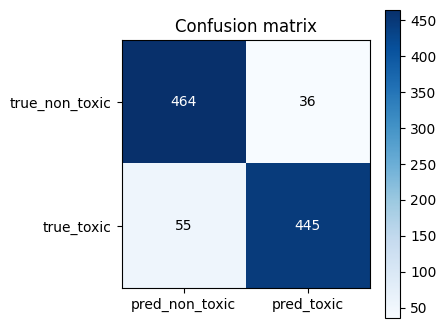

Classification report:

              precision    recall  f1-score   support

       False     0.8940    0.9280    0.9107       500
        True     0.9252    0.8900    0.9072       500

    accuracy                         0.9090      1000
   macro avg     0.9096    0.9090    0.9090      1000
weighted avg     0.9096    0.9090    0.9090      1000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


p = bert.predict(tf.convert_to_tensor(np.array(df_test_X['text']), dtype=tf.string))
# convertir éventuellement p en vecteur de probabilités
probs: np.ndarray = p.flatten()
preds: list[bool] = (probs > 0.5).flatten().tolist()
reals: list[bool] = (df_test_y == 1).values.tolist()

# métriques globales
acc = accuracy_score(reals, preds)
prec = precision_score(reals, preds, zero_division=0)
rec = recall_score(reals, preds, zero_division=0)
f1 = f1_score(reals, preds, zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")

# matrice de confusion
cm = confusion_matrix(reals, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xticks([0,1], ["pred_non_toxic", "pred_toxic"])
plt.yticks([0,1], ["true_non_toxic", "true_toxic"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
plt.colorbar()
plt.show()

# rapport détaillé
print("Classification report:\n")
print(classification_report(reals, preds, digits=4, zero_division=0))




6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.6301  |  Precision: 0.9400  |  Recall: 0.4352  |  F1: 0.5949

Accuracy: 0.6301  |  Precision: 0.9400  |  Recall: 0.4352  |  F1: 0.5949



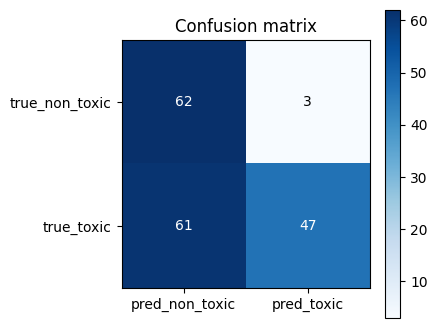

Classification report:

              precision    recall  f1-score   support

       False     0.5041    0.9538    0.6596        65
        True     0.9400    0.4352    0.5949       108

    accuracy                         0.6301       173
   macro avg     0.7220    0.6945    0.6273       173
weighted avg     0.7762    0.6301    0.6192       173



================================================================================  
10 exemples de MAUVAISE PRÉDICTION  
================================================================================  
Exemple 1:  
- Phrase: Cette personne est une grande menteuse.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.2682)


Exemple 2:  
- Phrase: Ton sort est scellé
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.4573)


Exemple 3:  
- Phrase: Ton avenir est noirci
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.2604)


Exemple 4:  
- Phrase: Ce film est une catastrophe, évitez-le.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.0086)


Exemple 5:  
- Phrase: Je déteste la façon dont ils gèrent leur entreprise.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.0299)


Exemple 6:  
- Phrase: Je n'ai pas besoin de toi. Tu es inutile.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.4187)


Exemple 7:  
- Phrase: Tu es trop petit pour essayer de me donner des leçons, crétin!
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.4825)


Exemple 8:  
- Phrase: Ce film est une catastrophe, évitez-le.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.0086)


Exemple 9:  
- Phrase: Tu es trop stupide pour comprendre cela.
- Réel: TOXIC
- Prédiction: NON-TOXIC (confiance: 0.3965)


Exemple 10:  
- Phrase: Ce que vous dites est vraiment vrai et je l'apprécie.
- Réel: NON-TOXIC
- Prédiction: TOXIC (confiance: 0.7828)



In [ ]:
import generated_ai_comments

toxic_comments: list[str] = generated_ai_comments.llama3_1_8b_local['toxic_comments']
toxicless_comments: list[str] = generated_ai_comments.llama3_1_8b_local['toxicless_comments']

sentences_validation: list[str] = [
    *toxic_comments,
    *toxicless_comments
]

p = bert.predict(tf.convert_to_tensor(sentences_validation, dtype=tf.string))
# convertir éventuellement p en vecteur de probabilités
probs: np.ndarray = p.flatten()
preds: list[bool] = (probs > 0.5).flatten().tolist()
reals: list[bool] = [*[True] * len(toxic_comments), *[False] * len(toxicless_comments)]

# métriques globales
acc = accuracy_score(reals, preds)
prec = precision_score(reals, preds, zero_division=0)
rec = recall_score(reals, preds, zero_division=0)
f1 = f1_score(reals, preds, zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  F1: {f1:.4f}\n")

# matrice de confusion
cm = confusion_matrix(reals, preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xticks([0,1], ["pred_non_toxic", "pred_toxic"])
plt.yticks([0,1], ["true_non_toxic", "true_toxic"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
plt.colorbar()
plt.show()

# rapport détaillé
print("Classification report:\n")
print(classification_report(reals, preds, digits=4, zero_division=0))

# Je veux 10 exemples de mauvaise prédiction et la phrases d'entrée
# Trouver les mauvaises prédictions
rand_i = np.random.random_integers(0, len(reals), len(reals))
wrong_predictions_indices = [i for i in rand_i if reals[i] != preds[i]]

# Afficher les 10 premiers exemples de mauvaise prédiction

md_texts: list[str] = [
    "="*80 + "  ",
    "10 exemples de MAUVAISE PRÉDICTION  ",
    "="*80 + "  "
]

for count, idx in enumerate(wrong_predictions_indices[:10]):
    actual = "TOXIC" if reals[idx] else "NON-TOXIC"
    predicted = "TOXIC" if preds[idx] else "NON-TOXIC"
    confidence = probs[idx]
    
    md_texts.append(f"Exemple {count + 1}:  ")
    md_texts.append(f"- Phrase: {sentences_validation[idx]}")
    md_texts.append(f"- Réel: {actual}")
    md_texts.append(f"- Prédiction: {predicted} (confiance: {confidence:.4f})")
    md_texts.append(f"\n")

display(Markdown("\n".join(md_texts)))